In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset
from torch.utils.data._utils.collate import default_collate

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from dataloading import repeat_channels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])
transform_eNetV2S = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [4]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.5  # overlap between consecutive windows

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform)

# split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/94 [00:00<?, ?it/s]

shot: 72966, len(instabilities) = 1, len(labels) = 2291
shot: 71193, len(instabilities) = 2, len(labels) = 2211
shot: 64678, len(instabilities) = 5, len(labels) = 3541
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 71226, len(instabilities) = 3, len(labels) = 2872
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 72927, len(instabilities) = 4, len(labels) = 1584
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 73020, len(instabilities) = 0, len(labels) = 4293
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 71222, len(instabilities) = 3, len(labels) = 2100
shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 72963, len(instabilities) = 7, len(labels) = 2063
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 64659, len(instabilities) = 3, len(labels)

In [5]:
import timm

# EfficientNetV2-S -- 20M params
#model = timm.create_model('tf_efficientnetv2_s', pretrained=True)

# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True)

# replace classifier layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # output one value
    #nn.ReLU(),
    #nn.Linear(640, 1),
    #nn.Sigmoid()
)

#summary(model.to('cpu'), (3, 224, 224))

In [6]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.BCEWithLogitsLoss()  #os_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 12
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=(len(train_loader.dataset) * num_epochs) // (train_loader.batch_size * 3),
                                        T_mult=1, verbose=False)

num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

In [7]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import precision_score, f1_score, cohen_kappa_score
import numpy as michayel


def safe_cohen_kappa_score(rater1, rater2):
    # Check for perfect agreement
    if michayel.array_equal(rater1, rater2):
        return 1.0

    # Check for no variation
    if michayel.unique(rater1).size == 1 and michayel.unique(rater2).size == 1:
        # Handle this case appropriately, maybe return NaN or a specific value
        return None

    # Calculate Cohen's Kappa
    try:
        return cohen_kappa_score(rater1, rater2)
    except ZeroDivisionError:
        # Handle division error
        return 0.0


def compute_metrics(predicted_probs, reference, threshold=0.5):
    """
    Compute the accuracy and f1 score for binary classification.

    @param predicted_logits: float32 tensor of shape (batch size, 1) representing raw model outputs (logits).
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = predicted_probs > threshold

    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_labels_np = predicted_labels.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision = precision_score(reference_np, predicted_labels_np, zero_division=0)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)
    kappa = safe_cohen_kappa_score(reference_np, predicted_labels_np)

    return precision, f1, kappa


def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []
    f1s_test = []
    f1s_train = []
    kappa_test = []
    kappa_train = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())

                losses.append(loss.item())

        model.eval()
        # evaluate on test set
        accuracies_test = []
        f1_test = []
        with tqdm(test_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1, kappa = compute_metrics(prediction, y_batch)
                    accuracies_test.append(acc)
                    f1_test.append(f1)
                    kappa_test.append(kappa)

        f1s_test.append(michayel.mean(f1_test))

        # evaluate on train set
        accuracies_train = []
        f1_train = []
        with tqdm(train_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1, kappa = compute_metrics(prediction, y_batch)
                    accuracies_train.append(acc)
                    f1_train.append(f1)
                    kappa_train.append(kappa)

        f1s_train.append(michayel.mean(f1_train))

        print(
            f"Epoch {epoch} | Train accuracy: {torch.tensor(accuracies_train).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_train).mean().item():.5f}, "
            f"kappa: {torch.tensor(kappa_train).mean().item():.5f}\n"
            f"           Test accuracy: {torch.tensor(accuracies_test).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_test).mean().item():.5f}, "
            f"kappa: {torch.tensor(kappa_test).mean().item():.5f}")

    plot_losses(losses)
    plot_f1(f1s_test, f1s_train)

    return f1s_train[-1], f1s_test[-1], kappa_train[-1], kappa_test[-1]


def plot_losses(losses):
    plt.plot(losses, label='train')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()


def plot_f1(f1s_test, f1s_train):
    plt.plot(f1s_test, label='test')
    plt.plot(f1s_train, label='train')
    plt.title("f1")
    plt.ylabel('f1')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

training on device 'mps'


Epoch 0:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.96887, f1: 0.98296, kappa: 0.97919
           Test accuracy: 0.94444, f1: 0.91225, kappa: 0.89289


Epoch 1:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.97023, f1: 0.98351, kappa: 0.97945
           Test accuracy: 0.98611, f1: 0.91566, kappa: 0.89555


Epoch 2:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.98069, f1: 0.98803, kappa: 0.98188
           Test accuracy: 1.00000, f1: 0.92718, kappa: 0.90099


Epoch 3:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 1.00000, kappa: 0.98641
           Test accuracy: 0.88492, f1: 0.89127, kappa: 0.89253


Epoch 4:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 1.00000, kappa: 0.98913
           Test accuracy: 0.96528, f1: 0.91944, kappa: 0.89429


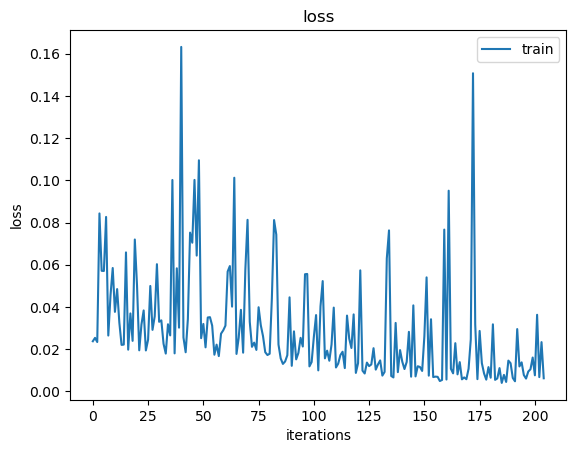

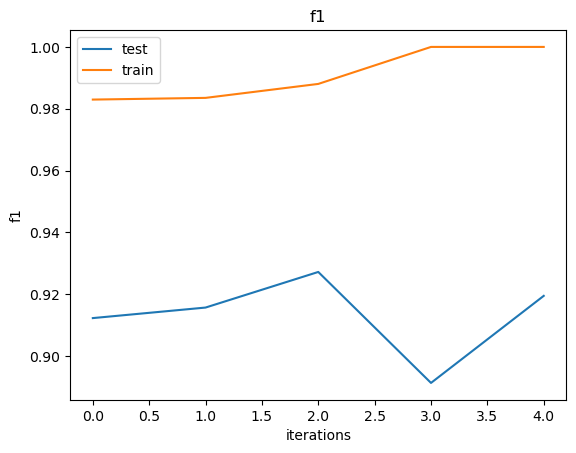

(1.0, 0.9194444444444445, 1.0, 0.7741935483870968)

In [11]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=5)

Fold 0


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

shot: 72966, len(instabilities) = 1, len(labels) = 2291
shot: 71193, len(instabilities) = 2, len(labels) = 2211
shot: 64678, len(instabilities) = 5, len(labels) = 3541
shot: 71226, len(instabilities) = 3, len(labels) = 2872
shot: 72927, len(instabilities) = 4, len(labels) = 1584
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 73020, len(instabilities) = 0, len(labels) = 4293
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 71222, len(instabilities) = 3, len(labels) = 2100
shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 72963, len(instabilities) = 7, len(labels) = 2063
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 73021, len(instabilities) = 1, len(labels) = 4293
shot: 71186, len(instabilities) = 3, len(labels) = 2034
shot: 72967, len(instabilities) = 9, len(labels)

Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 71223, len(instabilities) = 8, len(labels) = 1922
shot: 71266, len(instabilities) = 13, len(labels) = 3850
shot: 64778, len(instabilities) = 1, len(labels) = 2536
shot: 64401, len(instabilities) = 9, len(labels) = 3122
shot: 70356, len(instabilities) = 9, len(labels) = 2747
shot: 72929, len(instabilities) = 13, len(labels) = 2692
shot: 70394, len(instabilities) = 6, len(labels) = 1934
shot: 64820, len(instabilities) = 1, len(labels) = 2952
shot: 64670, len(instabilities) = 1, len(labels) = 2258
shot: 73019, len(instabilities) = 2, len(labels) = 4293
shot: 70392, len(instabilities) = 2, len(labels) = 2346
shot: 70355, len(instabilities) = 6, len(labels) = 2934
shot: 64686, len(instabilities) = 6, len(labels) = 3530
shot: 71255, len(instabilities) = 2, len(labels) = 2176
shot: 72925, len(instabilities) = 3, len(label

Epoch 0:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.87800, f1: 0.83192, kappa: 0.80467
           Test accuracy: 0.87558, f1: 0.83521, kappa: 0.80968


Epoch 1:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.92086, f1: 0.94651, kappa: 0.87040
           Test accuracy: 0.79910, f1: 0.80772, kappa: 0.79345


Epoch 2:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.95574, f1: 0.97290, kappa: 0.90247
           Test accuracy: 0.81021, f1: 0.81583, kappa: 0.79118


Epoch 3:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.93300, f1: 0.94953, kappa: 0.91932
           Test accuracy: 0.82623, f1: 0.80794, kappa: 0.78696


Epoch 4:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.97199, f1: 0.98246, kappa: 0.93119
           Test accuracy: 0.80967, f1: 0.81189, kappa: 0.78617


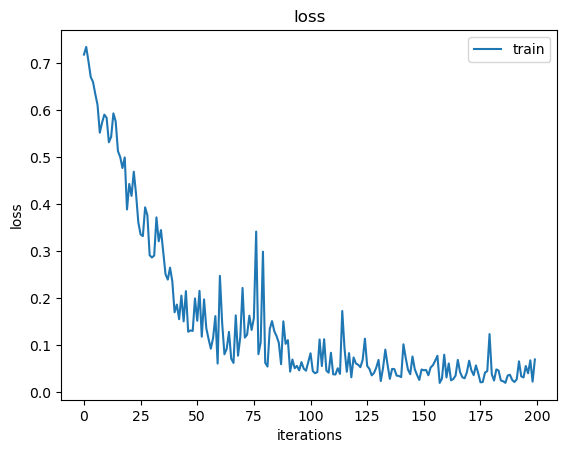

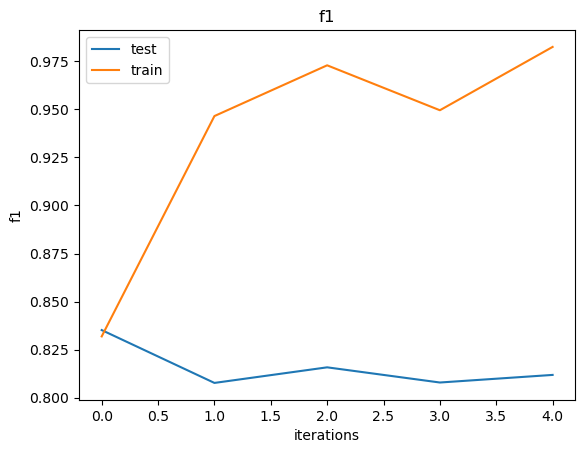

Fold 1


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

shot: 64678, len(instabilities) = 5, len(labels) = 3541
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 71226, len(instabilities) = 3, len(labels) = 2872
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 72927, len(instabilities) = 4, len(labels) = 1584
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 71222, len(instabilities) = 3, len(labels) = 2100
shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 72963, len(instabilities) = 7, len(labels) = 2063
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 71186, len(instabilities) = 3, len(labels) = 2034
shot: 71223, len(instabilities) = 8, len(labels) = 1922
shot: 72967, len(instabilities) = 9, len(labels) = 2418
shot: 71192, len(instabilities) = 2, len(labels) = 2135
shot: 71266, len(instabilities) = 13, len(labels

Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

shot: 72966, len(instabilities) = 1, len(labels) = 2291
shot: 71193, len(instabilities) = 2, len(labels) = 2211
shot: 73020, len(instabilities) = 0, len(labels) = 4293
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 73021, len(instabilities) = 1, len(labels) = 4293
shot: 71182, len(instabilities) = 5, len(labels) = 2252
shot: 70381, len(instabilities) = 8, len(labels) = 2805
shot: 70380, len(instabilities) = 5, len(labels) = 2913
shot: 64680, len(instabilities) = 12, len(labels) = 3256
shot: 64389, len(instabilities) = 8, len(labels) = 2288
shot: 71188, len(instabilities) = 1, len(labels) = 2000
shot: 73018, len(instabilities) = 4, len(labels) = 1397
shot: 70382, len(instabilities) = 4, len(labels) = 3573
shot: 64378, len(instabilities) = 5, len(labels) = 2104
shot: 64774, len(instabilities) = 1, len(labels) = 2291
shot: 72964, len(instabilities) = 3, len(labels) = 1864
shot: 72961, len(instabilities) = 10, len(label

Epoch 0:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.90377, f1: 0.86237, kappa: 0.83232
           Test accuracy: 0.37500, f1: 0.30833, kappa: 0.49306


Epoch 1:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.94308, f1: 0.94746, kappa: 0.89974
           Test accuracy: 0.68833, f1: 0.59167, kappa: 0.63217


Epoch 2:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 1.00000, f1: 0.99487, kappa: 0.93095
           Test accuracy: 0.54167, f1: 0.39833, kappa: 0.61437


Epoch 3:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 1.00000, kappa: 0.94821
           Test accuracy: 0.60000, f1: 0.47833, kappa: 0.62525


Epoch 4:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 1.00000, kappa: 0.95857
           Test accuracy: 0.58333, f1: 0.46833, kappa: 0.62948


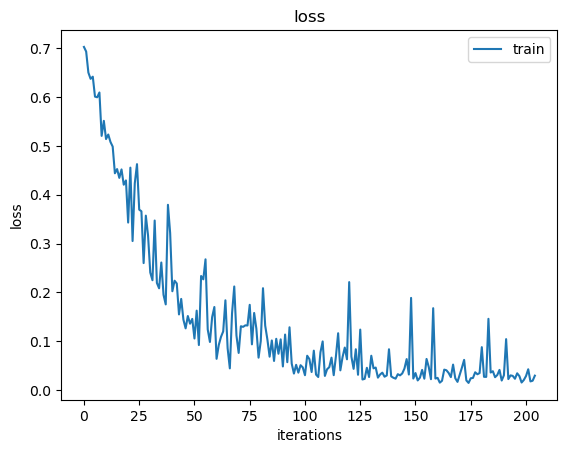

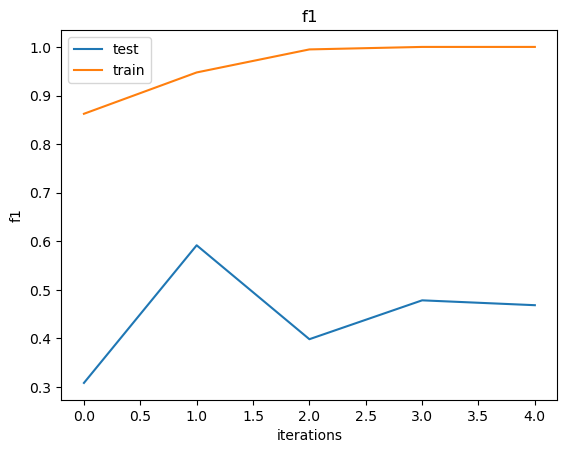

Fold 2


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

shot: 72966, len(instabilities) = 1, len(labels) = 2291
shot: 71193, len(instabilities) = 2, len(labels) = 2211
shot: 64678, len(instabilities) = 5, len(labels) = 3541
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 71226, len(instabilities) = 3, len(labels) = 2872
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 72927, len(instabilities) = 4, len(labels) = 1584
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 73020, len(instabilities) = 0, len(labels) = 4293
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 71222, len(instabilities) = 3, len(labels) = 2100
shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 72963, len(instabilities) = 7, len(labels) = 2063
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 73021, len(instabilities) = 1, len(labels)

Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 71259, len(instabilities) = 2, len(labels) = 2327
shot: 64662, len(instabilities) = 1, len(labels) = 1903
shot: 64666, len(instabilities) = 4, len(labels) = 1842
shot: 72196, len(instabilities) = 1, len(labels) = 2061
shot: 64673, len(instabilities) = 3, len(labels) = 3414
shot: 72959, len(instabilities) = 5, len(labels) = 4293
shot: 70357, len(instabilities) = 6, len(labels) = 2959
shot: 64650, len(instabilities) = 3, len(labels) = 3057
shot: 70383, len(instabilities) = 8, len(labels) = 3539
shot: 64682, len(instabilities) = 14, len(labels) = 3004
shot: 64770, len(instabilities) = 3, len(labels) = 3434
shot: 73022, len(instabilities) = 6, len(labels) = 2164
shot: 64394, len(instabilities) = 3, len(labels) = 2873
shot: 71224, len(instabilities) = 5, len(labels) = 2248
shot: 71190, len(instabilities) = 4, len(labels) = 2922
shot: 71264, len(instabilities) = 6, len(labels) = 3245
shot: 70388, len(instabilities) = 1, len(labels

Epoch 0:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.86984, f1: 0.80897, kappa: 0.78363
           Test accuracy: 0.50505, f1: 0.42026, kappa: 0.39958


Epoch 1:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.94283, f1: 0.96340, kappa: 0.86939
           Test accuracy: 0.62879, f1: 0.52797, kappa: 0.44807


Epoch 2:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.95844, f1: 0.96342, kappa: 0.89887
           Test accuracy: 0.60606, f1: 0.46996, kappa: 0.44538


Epoch 3:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.97976, f1: 0.98674, kappa: 0.92026
           Test accuracy: 0.65152, f1: 0.53057, kappa: 0.45933


Epoch 4:   0%|          | 0/40 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99143, f1: 0.99138, kappa: 0.93402
           Test accuracy: 0.65152, f1: 0.53057, kappa: 0.46770


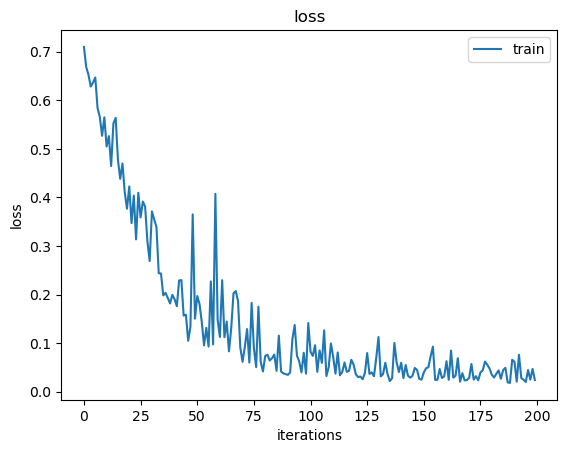

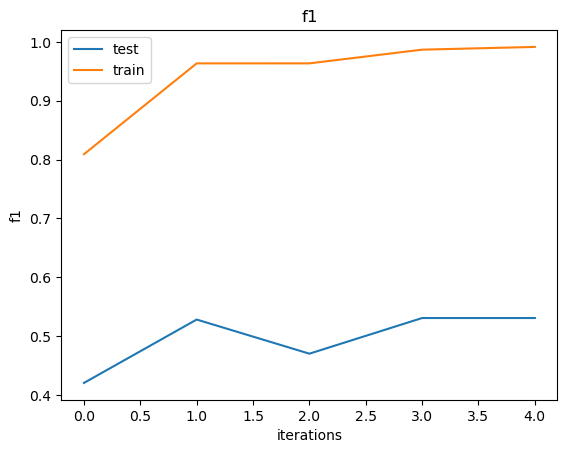

Fold 3


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

shot: 72966, len(instabilities) = 1, len(labels) = 2291
shot: 71193, len(instabilities) = 2, len(labels) = 2211
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 72927, len(instabilities) = 4, len(labels) = 1584
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 73020, len(instabilities) = 0, len(labels) = 4293
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 71222, len(instabilities) = 3, len(labels) = 2100
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 73021, len(instabilities) = 1, len(labels) = 4293
shot: 71186, len(instabilities) = 3, len(labels) = 2034
shot: 71223, len(instabilities) = 8, len(labels) = 1922
shot: 71192, len(instabilities) = 2, len(labels) = 2135
shot: 71266, len(instabilities) = 13, len(labels

Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

shot: 64678, len(instabilities) = 5, len(labels) = 3541
shot: 71226, len(instabilities) = 3, len(labels) = 2872
shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 72963, len(instabilities) = 7, len(labels) = 2063
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 72967, len(instabilities) = 9, len(labels) = 2418
shot: 72198, len(instabilities) = 0, len(labels) = 3508
shot: 70391, len(instabilities) = 5, len(labels) = 2690
shot: 71189, len(instabilities) = 1, len(labels) = 1911
shot: 64834, len(instabilities) = 2, len(labels) = 2954
shot: 64684, len(instabilities) = 4, len(labels) = 2698
shot: 72928, len(instabilities) = 5, len(labels) = 2407
shot: 70390, len(instabilities) = 2, len(labels) = 2106
shot: 70393, len(instabilities) = 6, len(labels) = 2414
shot: 64675, len(instabilities) = 4, len(labels) = 3047
shot: 71292, len(instabilities) = 3, len(labels) = 3711
shot: 72965, len(instabilities) = 6, len(labels) = 2569
shot: 72930, len(instabilities) = 9, len(labels)

Epoch 0:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.94033, f1: 0.89377, kappa: 0.87400
           Test accuracy: 0.66677, f1: 0.60874, kappa: 0.66054


Epoch 1:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.99430, f1: 0.97337, kappa: 0.92113
           Test accuracy: 0.69555, f1: 0.63576, kappa: 0.67693


Epoch 2:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 1.00000, f1: 0.99812, kappa: 0.94664
           Test accuracy: 0.79793, f1: 0.71407, kappa: 0.70887


Epoch 3:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 0.99755, kappa: 0.95909
           Test accuracy: 0.79945, f1: 0.70336, kappa: 0.72200


Epoch 4:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99837, kappa: 0.96685
           Test accuracy: 0.77196, f1: 0.70009, kappa: 0.72865


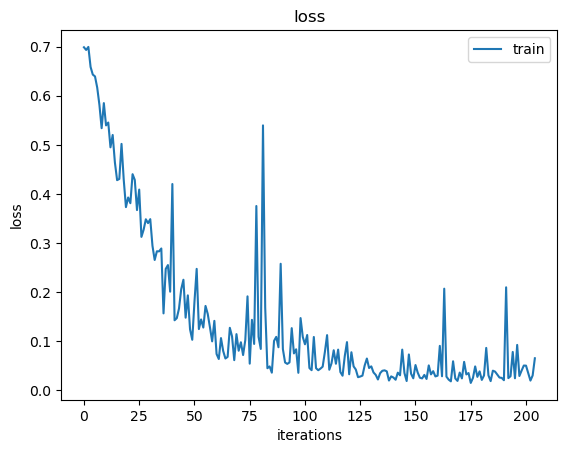

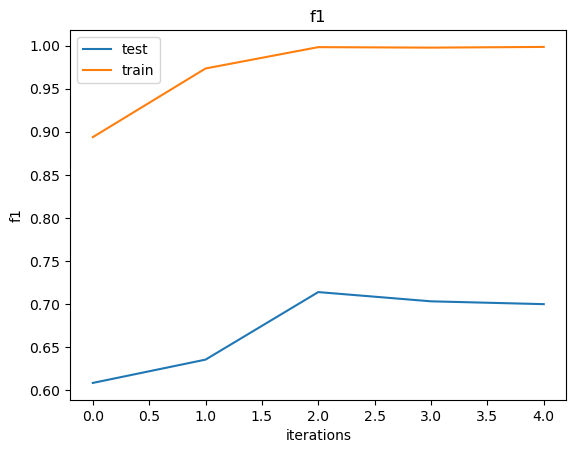

Fold 4


Processing dataset:   0%|          | 0/76 [00:00<?, ?it/s]

shot: 72966, len(instabilities) = 1, len(labels) = 2291
shot: 71193, len(instabilities) = 2, len(labels) = 2211
shot: 64678, len(instabilities) = 5, len(labels) = 3541
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 71226, len(instabilities) = 3, len(labels) = 2872
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 73020, len(instabilities) = 0, len(labels) = 4293
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 72963, len(instabilities) = 7, len(labels) = 2063
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 73021, len(instabilities) = 1, len(labels) = 4293
shot: 71223, len(instabilities) = 8, len(labels) = 1922
shot: 72967, len(instabilities) = 9, len(labels) = 2418
shot: 71266, len(instabilities) = 13, len(labels

Processing dataset:   0%|          | 0/18 [00:00<?, ?it/s]

shot: 72927, len(instabilities) = 4, len(labels) = 1584
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 71222, len(instabilities) = 3, len(labels) = 2100
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 71186, len(instabilities) = 3, len(labels) = 2034
shot: 71192, len(instabilities) = 2, len(labels) = 2135
shot: 72926, len(instabilities) = 8, len(labels) = 4293
shot: 64646, len(instabilities) = 0, len(labels) = 1911
shot: 72919, len(instabilities) = 6, len(labels) = 4293
shot: 64677, len(instabilities) = 8, len(labels) = 3016
shot: 64647, len(instabilities) = 6, len(labels) = 2278
shot: 70387, len(instabilities) = 5, len(labels) = 2604
shot: 64664, len(instabilities) = 1, len(labels) = 2055
shot: 71265, len(instabilities) = 2, len(labels) = 3239
shot: 70389, len(instabilities) = 5, len(labels) = 2247
shot: 71300, len(instabilities) = 1, len(labels) = 3231
shot: 64376, len(instabilities) = 2, len(labels) = 2057
shot: 71260, len(instabilities) = 5, len(labels)

Epoch 0:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.84893, f1: 0.79446, kappa: 0.76402
           Test accuracy: 0.77833, f1: 0.73555, kappa: 0.71540


Epoch 1:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.90385, f1: 0.94209, kappa: 0.84834
           Test accuracy: 0.98235, f1: 0.98263, kappa: 0.84358


Epoch 2:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.91190, f1: 0.92902, kappa: 0.89014
           Test accuracy: 0.78750, f1: 0.76024, kappa: 0.81204


Epoch 3:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.95366, f1: 0.97329, kappa: 0.91007
           Test accuracy: 0.78750, f1: 0.76024, kappa: 0.79627


Epoch 4:   0%|          | 0/41 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.98046, f1: 0.98935, kappa: 0.92546
           Test accuracy: 0.88750, f1: 0.85548, kappa: 0.80539


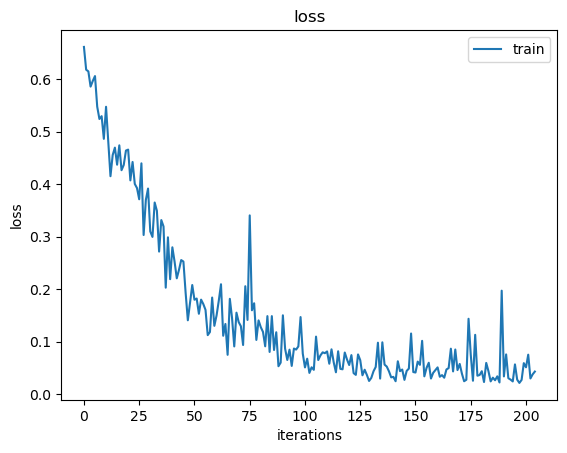

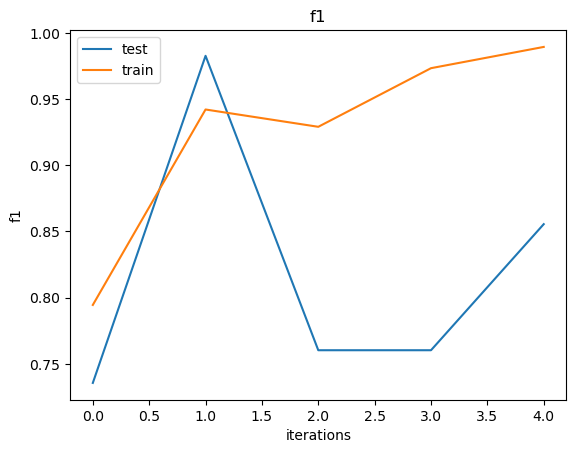

test f1: 0.6732716069620095 ± 0.15198530763891493
test kappa: 0.8534929356357928 ± 0.20736474333244062


In [8]:
from sklearn.model_selection import KFold

DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.25  # overlap between consecutive windows

shot_count = 94
shot_indices = michayel.arange(94)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

f1s_tr = []
f1s_te = []
kappas_tr = []
kappas_te = []

for fold, (train_ids, val_ids) in enumerate(kf.split(shot_indices)):
    print(f"Fold {fold}\n")

    train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                       file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                       overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_ids)
    val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                     file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                     overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

    # Init the neural network
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 1),  # output one value
    )

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  #pos_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits

    num_epochs = 5
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # Run the training loop for defined number of epochs
    f1_tr, f1_te, kappa_tr, kappa_te = train(model, train_loader, test_loader, optimizer, scheduler, criterion, device,
                                             n_epochs=5)
    f1s_tr.append(f1_tr)
    f1s_te.append(f1_te)
    kappas_tr.append(kappa_tr)
    kappas_te.append(kappa_te)

print(f"test f1: {michayel.mean(f1s_te)} ± {michayel.std(f1s_te)}")
print(f"test kappa: {michayel.mean(kappas_te)} ± {michayel.std(kappas_te)}")

In [15]:
kappas_te

[0.7980769230769231, 1.0, 0.4693877551020408, 1.0, 1.0]